In [29]:
import numpy as np
import seaborn as sns
import torch

import umap
import matplotlib.pyplot as plt
import pandas as pd
from community import community_louvain
from torch_geometric.utils import k_hop_subgraph,to_networkx,from_networkx
import matplotlib

import utils
import plots
from model_AE import reduction_AE
from model_GAT import Encoder,SenGAE,train_GAT
from model_Sencell import Sencell

import logging
import os
import argparse
from tqdm import tqdm

parser = argparse.ArgumentParser(description='Main program for sencells')

parser.add_argument('--output_dir', type=str, default='./outputs', help='')
parser.add_argument('--exp_name', type=str, default='', help='')

args = parser.parse_args(args=[])

args.exp_name='s5'

if not os.path.exists(args.output_dir):
    os.makedirs(args.output_dir)

logging.basicConfig(format='%(asctime)s.%(msecs)03d [%(levelname)s] [%(filename)s:%(lineno)d] %(message)s',
                    datefmt='# %Y-%m-%d %H:%M:%S')

logging.getLogger().setLevel(logging.INFO)
logger = logging.getLogger()

# Part 1: load and process data
# cell_cluster_arr在画umap的时候用
adata,cluster_cell_ls,cell_cluster_arr,celltype_names=utils.load_data()
# plots.umapPlot(adata.obsm['X_umap'],clusters=cell_cluster_arr,labels=celltype_names)

new_data,markers_index,\
sen_gene_ls,nonsen_gene_ls,gene_names=utils.process_data(adata,cluster_cell_ls,cell_cluster_arr)

print(f'cell num: {new_data.shape[0]}, gene num: {new_data.shape[1]}')

gene_cell=new_data.X.toarray().T
cell_gene=gene_cell.T
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device: ',device)

cluster 数量： 21
celltype names: ['Macrophages', 'T cell lineage', 'Unknown', 'B cell lineage', 'Innate lymphoid cell NK', 'AT2', 'Monocytes', 'Multiciliated lineage', 'Dendritic cells', 'EC capillary', 'Mast cells', 'Fibroblasts', 'Secretory', 'EC venous', 'Lymphatic EC mature', 'AT1', 'Basal', 'EC arterial', 'Myofibroblasts', 'None', 'Submucosal Secretory']
-----------------------  ----
Macrophages              6941
T cell lineage            749
Unknown                   618
B cell lineage            374
Innate lymphoid cell NK   327
AT2                       294
Monocytes                 228
Multiciliated lineage     194
Dendritic cells           177
EC capillary              138
Mast cells                100
Fibroblasts                93
Secretory                  86
EC venous                  74
Lymphatic EC mature        68
AT1                        27
Basal                      26
EC arterial                20
Myofibroblasts             17
None                        6
Submucosal

In [2]:
%%time
def get_simi(i,my_dict):
    for j in range(i+1,cell_gene.shape[0]):
        u1=cell_gene[i]
        u2=cell_gene[j]
        # u1,u2必须是numpy.array，not tensor
        nz_u1 = u1.nonzero()[0]
        nz_u2 = u2.nonzero()[0]
        nz_inter = set(nz_u1) & set(nz_u2)
        nz_union = set(nz_u1) | set(nz_u2)
        if len(nz_inter) == 0:
            simi_score = 1 / (len(nz_union) + len(u1))
        elif len(nz_inter) == len(nz_union):
            simi_score = (len(nz_union) + len(u1) - 1) / (len(nz_union) + len(u1))
        else:
            simi_score = len(nz_inter) / len(nz_union)
        my_dict[(i,j)]=simi_score


def eucliDistance(v1,v2):
    # 计算欧氏距离
    return F.pairwise_distance(v1.view(1,-1),v2.view(1,-1),p=2)

def loss_exp(v1,v2):
    return torch.exp(-0.1*eucliDistance(v1,v2))


sim1_ls=[]
cell_gene=gene_cell.T    
results_matrix=np.zeros((cell_gene.shape[0],cell_gene.shape[0])) 


from multiprocessing import Pool,Manager
import os, time, random


print('Parent process %s.' % os.getpid())
p = Pool()
manager = Manager()
my_dict = manager.dict()
for i in tqdm(range(cell_gene.shape[0])):
    p.apply_async(get_simi, args=(i,my_dict,))

print('Waiting for all subprocesses done...')
p.close()
p.join()
print('All subprocesses done.')

Parent process 156409.


100%|██████████| 10558/10558 [00:00<00:00, 35942.79it/s]


Waiting for all subprocesses done...
All subprocesses done.
CPU times: user 3.27 s, sys: 1.38 s, total: 4.64 s
Wall time: 55min 10s


In [4]:
torch.save(my_dict,"./my_dict")

In [5]:
my_dict[(0,1)]

0.07983193277310924

In [6]:
a=torch.load("./my_dict")

In [8]:
a[(0,100)]

0.03289473684210526

In [9]:
from utils import save_objs

save_objs(my_dict,"./my_dict.pl")

obj saved ./my_dict.pl


In [ ]:
# 17:17

In [10]:
for i in tqdm(range(cell_gene.shape[0])):
    for j in range(i+1,cell_gene.shape[0]):
        results_matrix[i][j]=my_dict[(i,j)]

100%|██████████| 10558/10558 [31:46<00:00,  5.54it/s] 


In [12]:
torch.save(results_matrix,"./results_matrix")

In [44]:
bool_arr=torch.tensor(1*(cell_gene==0)).to(device)

In [19]:
sim1=torch.tensor(results_matrix).to(device)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0000, -0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1797,  0.0000,  0.0000,  ..., -0.0000,  0.0000,  0.0000]],
       device='cuda:0', grad_fn=<MulBackward0>)

In [68]:
%%time
import torch
from torch import nn, optim
from torch.nn import functional as F
import torch.utils.data as Data
import numpy as np


class AE(nn.Module):
    def __init__(self, dim, emb_dim=128):
        super(AE, self).__init__()
        self.dim = dim
        self.fc1 = nn.Linear(dim, 512)
        self.fc2 = nn.Linear(512, emb_dim)
        self.fc3 = nn.Linear(emb_dim, 512)
        self.fc4 = nn.Linear(512, dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return F.relu(self.fc2(h1))

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.relu(self.fc4(h3))

    def forward(self, x):
        z = self.encode(x.view(-1, self.dim))
        return self.decode(z), z
    
    
feature=torch.tensor(gene_cell.T)
feature=feature.to(device)
model = AE(dim=feature.shape[1]).to(device)
ba=feature.shape[0]
loader = Data.DataLoader(feature, ba)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def loss_expmatrix(encoded):
    return torch.exp(-0.1*torch.cdist(encoded,encoded))


def get_loss1(batch_x, decoded,bool_arr):
    return torch.abs((batch_x-decoded)*bool_arr).sum()


loss_func = nn.MSELoss()
EPOCH_AE = 2000
for epoch in range(EPOCH_AE):
    embeddings = []
    # loss_ls=[]
    for _, batch_x in enumerate(loader):
        decoded, encoded = model(batch_x)
#         if epoch %2  ==0:
#             loss1 = get_loss1(batch_x, decoded,bool_arr)
#         else:
        loss1=loss_func(batch_x,decoded)
        sim2=loss_expmatrix(encoded)
        loss2=10*(sim1*(torch.triu(sim2-sim1).abs())).mean()
        print(loss1.item(),loss2.item())
        loss=loss1+loss2
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        embeddings.append(encoded)
    #     loss_ls.append(loss.item())
    # scheduler.step(np.mean(loss_ls))
    print('Epoch :', epoch, '|', 'train_loss:%.12f' % loss.data)
#     break

0.1708962321281433 0.7118785437114148
Epoch : 0 | train_loss:0.882774775840
0.16793963313102722 0.6656433636494935
Epoch : 1 | train_loss:0.833582996781
0.16152916848659515 0.6165209743689954
Epoch : 2 | train_loss:0.778050142856
0.15216512978076935 0.562801331543929
Epoch : 3 | train_loss:0.714966461325
0.14431104063987732 0.5039958455393712
Epoch : 4 | train_loss:0.648306886179
0.14084160327911377 0.44097283295416656
Epoch : 5 | train_loss:0.581814436233
0.13875281810760498 0.37817224352909107
Epoch : 6 | train_loss:0.516925061637
0.134443461894989 0.31930900843718407
Epoch : 7 | train_loss:0.453752470332
0.12806689739227295 0.26544836164683966
Epoch : 8 | train_loss:0.393515259039
0.1207534670829773 0.2179095267681499
Epoch : 9 | train_loss:0.338662993851
0.1148814782500267 0.18014597524503698
Epoch : 10 | train_loss:0.295027453495
0.11288569122552872 0.15642693121387685
Epoch : 11 | train_loss:0.269312622439
0.11277997493743896 0.14518054705959774
Epoch : 12 | train_loss:0.25796052

0.07736320793628693 0.039615282272960795
Epoch : 106 | train_loss:0.116978490209
0.07688687741756439 0.03924686288109235
Epoch : 107 | train_loss:0.116133740299
0.07651743292808533 0.03889311460374947
Epoch : 108 | train_loss:0.115410547532
0.07629422098398209 0.03854412771926128
Epoch : 109 | train_loss:0.114838348703
0.07620344310998917 0.03818856487811884
Epoch : 110 | train_loss:0.114392007988
0.07614196836948395 0.03782662188251436
Epoch : 111 | train_loss:0.113968590252
0.0760202631354332 0.037467106710646826
Epoch : 112 | train_loss:0.113487369846
0.07583703845739365 0.03711723574441723
Epoch : 113 | train_loss:0.112954274202
0.07560402899980545 0.03678309770097983
Epoch : 114 | train_loss:0.112387126701
0.07539516687393188 0.03646492724205141
Epoch : 115 | train_loss:0.111860094116
0.07521449774503708 0.03615604650510518
Epoch : 116 | train_loss:0.111370544250
0.07508029043674469 0.035849357490869295
Epoch : 117 | train_loss:0.110929647928
0.07496192306280136 0.0355393088957620

0.06441622227430344 0.02218196764963922
Epoch : 208 | train_loss:0.086598189924
0.06430891156196594 0.022118827961322536
Epoch : 209 | train_loss:0.086427739523
0.06421475112438202 0.02205673146922105
Epoch : 210 | train_loss:0.086271482594
0.06412819027900696 0.021996517376459246
Epoch : 211 | train_loss:0.086124707655
0.0640370100736618 0.021933661954285262
Epoch : 212 | train_loss:0.085970672028
0.06393861025571823 0.021881214305419984
Epoch : 213 | train_loss:0.085819824561
0.06386168301105499 0.021815057111945372
Epoch : 214 | train_loss:0.085676740123
0.06377695500850677 0.02176256948515139
Epoch : 215 | train_loss:0.085539524494
0.06372802704572678 0.02169919351831129
Epoch : 216 | train_loss:0.085427220564
0.06368138641119003 0.021660830466178446
Epoch : 217 | train_loss:0.085342216877
0.06367575377225876 0.021608980946291698
Epoch : 218 | train_loss:0.085284734719
0.06363469362258911 0.02162384504555651
Epoch : 219 | train_loss:0.085258538668
0.063595250248909 0.02154138535156

0.05659709870815277 0.018422612760444875
Epoch : 312 | train_loss:0.075019711469
0.05661600083112717 0.018371594928547542
Epoch : 313 | train_loss:0.074987595760
0.056593142449855804 0.01838163844165416
Epoch : 314 | train_loss:0.074974780892
0.056611381471157074 0.01833981272599178
Epoch : 315 | train_loss:0.074951194197
0.05657970532774925 0.01836362491810045
Epoch : 316 | train_loss:0.074943330246
0.056589726358652115 0.018317589458339972
Epoch : 317 | train_loss:0.074907315817
0.05655357241630554 0.018346624541456337
Epoch : 318 | train_loss:0.074900196958
0.05650001019239426 0.01827703852206568
Epoch : 319 | train_loss:0.074777048714
0.05630674958229065 0.018266170238743294
Epoch : 320 | train_loss:0.074572919821
0.056117333471775055 0.01819811871362577
Epoch : 321 | train_loss:0.074315452185
0.05600224807858467 0.01817363456730524
Epoch : 322 | train_loss:0.074175882646
0.055991031229496 0.018187513927238178
Epoch : 323 | train_loss:0.074178545157
0.056010715663433075 0.018166323

0.051422830671072006 0.016838753518805188
Epoch : 416 | train_loss:0.068261584190
0.05135063827037811 0.016811505897145262
Epoch : 417 | train_loss:0.068162144168
0.051271967589855194 0.01680120039016905
Epoch : 418 | train_loss:0.068073167980
0.05121304467320442 0.016815322745700776
Epoch : 419 | train_loss:0.068028367419
0.05120948702096939 0.016785486080084674
Epoch : 420 | train_loss:0.067994973101
0.05115699768066406 0.016782071745337423
Epoch : 421 | train_loss:0.067939069426
0.051106471568346024 0.016758736526013188
Epoch : 422 | train_loss:0.067865208094
0.0510474294424057 0.016750308977796544
Epoch : 423 | train_loss:0.067797738420
0.05101700872182846 0.016741179578424775
Epoch : 424 | train_loss:0.067758188300
0.05100006237626076 0.016730912867627602
Epoch : 425 | train_loss:0.067730975244
0.05095731467008591 0.01671829138505874
Epoch : 426 | train_loss:0.067675606055
0.050887979567050934 0.016720126619488684
Epoch : 427 | train_loss:0.067608106187
0.05087738111615181 0.01670

0.04780366271734238 0.01599649245882246
Epoch : 518 | train_loss:0.063800155176
0.04778077080845833 0.015979866357141544
Epoch : 519 | train_loss:0.063760637166
0.047729749232530594 0.01598278910362212
Epoch : 520 | train_loss:0.063712538336
0.0477154403924942 0.01596631099417802
Epoch : 521 | train_loss:0.063681751387
0.047704752534627914 0.01596665155087812
Epoch : 522 | train_loss:0.063671404086
0.04769919812679291 0.01595369630686536
Epoch : 523 | train_loss:0.063652894434
0.047690629959106445 0.015958580155901462
Epoch : 524 | train_loss:0.063649210115
0.04771023988723755 0.015944883475675884
Epoch : 525 | train_loss:0.063655123363
0.047733526676893234 0.015965263271304667
Epoch : 526 | train_loss:0.063698789948
0.04777858406305313 0.015948510719329873
Epoch : 527 | train_loss:0.063727094782
0.047780655324459076 0.01597785234366325
Epoch : 528 | train_loss:0.063758507668
0.047779299318790436 0.015946689801969963
Epoch : 529 | train_loss:0.063725989121
0.04776011034846306 0.0159682

0.045338764786720276 0.015451875864209572
Epoch : 620 | train_loss:0.060790640651
0.04528140649199486 0.015449091274753251
Epoch : 621 | train_loss:0.060730497767
0.04525208845734596 0.015446588787664604
Epoch : 622 | train_loss:0.060698677245
0.045254386961460114 0.015439245315251874
Epoch : 623 | train_loss:0.060693632277
0.04525523632764816 0.015439490167961232
Epoch : 624 | train_loss:0.060694726496
0.04524162411689758 0.015430257622586017
Epoch : 625 | train_loss:0.060671881739
0.04519529268145561 0.015430889057898387
Epoch : 626 | train_loss:0.060626181739
0.04514892026782036 0.015421485507862646
Epoch : 627 | train_loss:0.060570405776
0.045108404010534286 0.015425834455011226
Epoch : 628 | train_loss:0.060534238466
0.04510847479104996 0.015414618012235932
Epoch : 629 | train_loss:0.060523092803
0.04510432109236717 0.015426182500488429
Epoch : 630 | train_loss:0.060530503593
0.04512834921479225 0.01541147599093702
Epoch : 631 | train_loss:0.060539825206
0.04511973634362221 0.0154

0.04347733408212662 0.015067998193009217
Epoch : 724 | train_loss:0.058545332275
0.04348145052790642 0.015063176623080255
Epoch : 725 | train_loss:0.058544627151
0.0434916689991951 0.015059631102130076
Epoch : 726 | train_loss:0.058551300101
0.04346884787082672 0.015065227495644087
Epoch : 727 | train_loss:0.058534075366
0.04344187676906586 0.015055596707233578
Epoch : 728 | train_loss:0.058497473476
0.04339514672756195 0.015060742517934617
Epoch : 729 | train_loss:0.058455889245
0.04338480159640312 0.015046123083470496
Epoch : 730 | train_loss:0.058430924680
0.04338136315345764 0.015047064299264237
Epoch : 731 | train_loss:0.058428427453
0.04339199513196945 0.015039697199226806
Epoch : 732 | train_loss:0.058431692331
0.043397314846515656 0.015038177281645566
Epoch : 733 | train_loss:0.058435492128
0.04339001700282097 0.015034003360840442
Epoch : 734 | train_loss:0.058424020364
0.04338549077510834 0.015032197899727425
Epoch : 735 | train_loss:0.058417688675
0.043387655168771744 0.01502

0.04223437234759331 0.014769565754556386
Epoch : 826 | train_loss:0.057003938102
0.04221411794424057 0.014773176098793625
Epoch : 827 | train_loss:0.056987294043
0.04219209775328636 0.014765016993129097
Epoch : 828 | train_loss:0.056957114746
0.04216033220291138 0.01477204177833749
Epoch : 829 | train_loss:0.056932373981
0.042134661227464676 0.014761375494218498
Epoch : 830 | train_loss:0.056896036722
0.04211227223277092 0.014766357144550562
Epoch : 831 | train_loss:0.056878629377
0.04211987182497978 0.014754754333648035
Epoch : 832 | train_loss:0.056874626159
0.04212556034326553 0.014756693720339744
Epoch : 833 | train_loss:0.056882254064
0.04212220758199692 0.014748749406782582
Epoch : 834 | train_loss:0.056870956989
0.04209611937403679 0.01474836284039118
Epoch : 835 | train_loss:0.056844482214
0.042073749005794525 0.014743623953416525
Epoch : 836 | train_loss:0.056817372959
0.04207857325673103 0.014744518116762306
Epoch : 837 | train_loss:0.056823091373
0.042128439992666245 0.01473

0.041179295629262924 0.014536550784836864
Epoch : 928 | train_loss:0.055715846414
0.04111316427588463 0.01452731513662513
Epoch : 929 | train_loss:0.055640479413
0.04106674715876579 0.01453254950739322
Epoch : 930 | train_loss:0.055599296666
0.04107026010751724 0.014524395983348077
Epoch : 931 | train_loss:0.055594656091
0.04108909144997597 0.01452884815204808
Epoch : 932 | train_loss:0.055617939602
0.04112936183810234 0.014520860314362227
Epoch : 933 | train_loss:0.055650222152
0.04113328829407692 0.014522004742200832
Epoch : 934 | train_loss:0.055655293036
0.04114740714430809 0.014516321060237942
Epoch : 935 | train_loss:0.055663728205
0.0411384180188179 0.014515707146113357
Epoch : 936 | train_loss:0.055654125165
0.04117244854569435 0.014512722296404032
Epoch : 937 | train_loss:0.055685170842
0.04118549823760986 0.014511290683465653
Epoch : 938 | train_loss:0.055696788921
0.041185587644577026 0.014507910546709931
Epoch : 939 | train_loss:0.055693498191
0.04115350916981697 0.01450841

0.04014889895915985 0.014332501838970457
Epoch : 1029 | train_loss:0.054481400798
0.0401432067155838 0.014329775498206618
Epoch : 1030 | train_loss:0.054472982214
0.0401480570435524 0.0143287893389912
Epoch : 1031 | train_loss:0.054476846383
0.040151454508304596 0.014326373300531953
Epoch : 1032 | train_loss:0.054477827809
0.04014642536640167 0.014326232329177535
Epoch : 1033 | train_loss:0.054472657696
0.0401432178914547 0.014322650033193805
Epoch : 1034 | train_loss:0.054465867925
0.04014938697218895 0.014325773548102367
Epoch : 1035 | train_loss:0.054475160520
0.04017975553870201 0.01431992666053725
Epoch : 1036 | train_loss:0.054499682199
0.04021827131509781 0.01432539137483603
Epoch : 1037 | train_loss:0.054543662690
0.04025996848940849 0.014317171706309247
Epoch : 1038 | train_loss:0.054577140196
0.04030711203813553 0.014323073870147515
Epoch : 1039 | train_loss:0.054630185908
0.040342576801776886 0.014313402063582968
Epoch : 1040 | train_loss:0.054655978865
0.04040203616023064 0

0.03957083821296692 0.01417033821293906
Epoch : 1131 | train_loss:0.053741176426
0.03959761559963226 0.014181359312494039
Epoch : 1132 | train_loss:0.053778974912
0.03963007405400276 0.014167970738823752
Epoch : 1133 | train_loss:0.053798044793
0.03963964805006981 0.014178305786699857
Epoch : 1134 | train_loss:0.053817953837
0.03961651399731636 0.014163693167041547
Epoch : 1135 | train_loss:0.053780207164
0.039594441652297974 0.014170085938039548
Epoch : 1136 | train_loss:0.053764527590
0.03957536071538925 0.014154973542966685
Epoch : 1137 | train_loss:0.053730334258
0.03957725316286087 0.014156480497932234
Epoch : 1138 | train_loss:0.053733733661
0.039561931043863297 0.014148614192948484
Epoch : 1139 | train_loss:0.053710545237
0.03954184055328369 0.014147459307970752
Epoch : 1140 | train_loss:0.053689299861
0.039515916258096695 0.014151095305516781
Epoch : 1141 | train_loss:0.053667011564
0.03950577601790428 0.014147777069840845
Epoch : 1142 | train_loss:0.053653553088
0.039503496140

0.03884612396359444 0.01401863497600428
Epoch : 1233 | train_loss:0.052864758940
0.03882092237472534 0.014018808637231518
Epoch : 1234 | train_loss:0.052839731012
0.03883004188537598 0.014013014710527072
Epoch : 1235 | train_loss:0.052843056596
0.03883460909128189 0.014012034016466196
Epoch : 1236 | train_loss:0.052846643108
0.038817938417196274 0.014012535510379336
Epoch : 1237 | train_loss:0.052830473928
0.03879968076944351 0.014008826812669243
Epoch : 1238 | train_loss:0.052808507582
0.03878958150744438 0.014008072104589646
Epoch : 1239 | train_loss:0.052797653612
0.03879193961620331 0.014008444873562311
Epoch : 1240 | train_loss:0.052800384490
0.03879447653889656 0.01400553166300816
Epoch : 1241 | train_loss:0.052800008202
0.03878479450941086 0.014010092957646932
Epoch : 1242 | train_loss:0.052794887467
0.03878586366772652 0.014003860864050192
Epoch : 1243 | train_loss:0.052789724532
0.0387866385281086 0.01400738007553635
Epoch : 1244 | train_loss:0.052794018604
0.03881398588418960

0.038492828607559204 0.01389587594959233
Epoch : 1334 | train_loss:0.052388704557
0.03845759853720665 0.01388985230250658
Epoch : 1335 | train_loss:0.052347450840
0.03841529041528702 0.013889332633465885
Epoch : 1336 | train_loss:0.052304623049
0.038415584713220596 0.013887191001347263
Epoch : 1337 | train_loss:0.052302775715
0.03845741227269173 0.0138863300802926
Epoch : 1338 | train_loss:0.052343742353
0.03850563243031502 0.013888401704671116
Epoch : 1339 | train_loss:0.052394034135
0.03853567689657211 0.01388543841915698
Epoch : 1340 | train_loss:0.052421115316
0.03850157931447029 0.013887954291579858
Epoch : 1341 | train_loss:0.052389533606
0.03845558688044548 0.01388195927542017
Epoch : 1342 | train_loss:0.052337546156
0.03839891776442528 0.013883493429515626
Epoch : 1343 | train_loss:0.052282411194
0.03838200494647026 0.013878698105730254
Epoch : 1344 | train_loss:0.052260703052
0.03837627172470093 0.01387948899571157
Epoch : 1345 | train_loss:0.052255760720
0.038374267518520355 

0.03803298622369766 0.013785828527528896
Epoch : 1436 | train_loss:0.051818814751
0.03806842491030693 0.013782326777778832
Epoch : 1437 | train_loss:0.051850751688
0.03812188282608986 0.013788162562963068
Epoch : 1438 | train_loss:0.051910045389
0.03813366964459419 0.013783481648490371
Epoch : 1439 | train_loss:0.051917151293
0.038148052990436554 0.01379063524133089
Epoch : 1440 | train_loss:0.051938688232
0.038131941109895706 0.013783926261605047
Epoch : 1441 | train_loss:0.051915867372
0.038117289543151855 0.013793285181942581
Epoch : 1442 | train_loss:0.051910574725
0.03810584545135498 0.013784361935758943
Epoch : 1443 | train_loss:0.051890207387
0.03805992007255554 0.013788384522561897
Epoch : 1444 | train_loss:0.051848304595
0.03801115229725838 0.01377709000635063
Epoch : 1445 | train_loss:0.051788242304
0.037939365953207016 0.01377778631412014
Epoch : 1446 | train_loss:0.051717152267
0.03788914531469345 0.013771077655186557
Epoch : 1447 | train_loss:0.051660222970
0.0378657318651

0.038217123597860336 0.013699945401596672
Epoch : 1538 | train_loss:0.051917068999
0.03819526359438896 0.013694159197732016
Epoch : 1539 | train_loss:0.051889422792
0.03802839294075966 0.013689633558236693
Epoch : 1540 | train_loss:0.051718026499
0.03783823549747467 0.01369250361749785
Epoch : 1541 | train_loss:0.051530739115
0.03772246837615967 0.013693126870869448
Epoch : 1542 | train_loss:0.051415595247
0.03772640600800514 0.013714284618461822
Epoch : 1543 | train_loss:0.051440690626
0.03779243677854538 0.01370782009135753
Epoch : 1544 | train_loss:0.051500256870
0.03783075138926506 0.013710920143713964
Epoch : 1545 | train_loss:0.051541671533
0.03779708966612816 0.01368912459889915
Epoch : 1546 | train_loss:0.051486214265
0.03773754462599754 0.013685117571138434
Epoch : 1547 | train_loss:0.051422662197
0.0377170629799366 0.013684124924058513
Epoch : 1548 | train_loss:0.051401187904
0.03777129948139191 0.013683285726004961
Epoch : 1549 | train_loss:0.051454585207
0.03781949356198311

0.037487540394067764 0.013611859350532697
Epoch : 1639 | train_loss:0.051099399745
0.03753829747438431 0.013614005613184538
Epoch : 1640 | train_loss:0.051152303088
0.037595536559820175 0.013610780581892513
Epoch : 1641 | train_loss:0.051206317142
0.03762545809149742 0.013614895358007355
Epoch : 1642 | train_loss:0.051240353450
0.037604182958602905 0.013610375748635132
Epoch : 1643 | train_loss:0.051214558707
0.037536680698394775 0.013611920979017821
Epoch : 1644 | train_loss:0.051148601677
0.03744868189096451 0.013607300034671598
Epoch : 1645 | train_loss:0.051055981926
0.0373845137655735 0.013605975382739315
Epoch : 1646 | train_loss:0.050990489148
0.03739447891712189 0.013610395154006336
Epoch : 1647 | train_loss:0.051004874071
0.03745466098189354 0.013610180530198846
Epoch : 1648 | train_loss:0.051064841512
0.03755844756960869 0.013623537169071257
Epoch : 1649 | train_loss:0.051181984739
0.03762728348374367 0.013620761110505402
Epoch : 1650 | train_loss:0.051248044594
0.03764433786

0.037095434963703156 0.013540042676124442
Epoch : 1741 | train_loss:0.050635477640
0.03705941140651703 0.013540199851862103
Epoch : 1742 | train_loss:0.050599611258
0.037045300006866455 0.013538971538137774
Epoch : 1743 | train_loss:0.050584271545
0.03705732151865959 0.013538587025361787
Epoch : 1744 | train_loss:0.050595908544
0.037092410027980804 0.013538112433389881
Epoch : 1745 | train_loss:0.050630522461
0.03715743124485016 0.013538030979937409
Epoch : 1746 | train_loss:0.050695462225
0.03723926469683647 0.013538542863069443
Epoch : 1747 | train_loss:0.050777807560
0.03736644238233566 0.013542202739344766
Epoch : 1748 | train_loss:0.050908645122
0.037444937974214554 0.013542083917401533
Epoch : 1749 | train_loss:0.050987021892
0.03756633773446083 0.013547248516059117
Epoch : 1750 | train_loss:0.051113586251
0.03752885386347771 0.013544644387282296
Epoch : 1751 | train_loss:0.051073498251
0.037524644285440445 0.01355480589474112
Epoch : 1752 | train_loss:0.051079450180
0.0373976156

0.03685906156897545 0.013476593463734591
Epoch : 1843 | train_loss:0.050335655033
0.03683323785662651 0.013476657888161749
Epoch : 1844 | train_loss:0.050309895745
0.036809127777814865 0.013475334103435124
Epoch : 1845 | train_loss:0.050284461881
0.03679138794541359 0.013475080275350021
Epoch : 1846 | train_loss:0.050266468221
0.036777667701244354 0.013474144197957607
Epoch : 1847 | train_loss:0.050251811899
0.0367683544754982 0.013472980756326998
Epoch : 1848 | train_loss:0.050241335232
0.03677039593458176 0.013473298481776667
Epoch : 1849 | train_loss:0.050243694416
0.03677660971879959 0.013472160610313933
Epoch : 1850 | train_loss:0.050248770329
0.03678899258375168 0.013472863018971102
Epoch : 1851 | train_loss:0.050261855603
0.03679089993238449 0.013471219181187107
Epoch : 1852 | train_loss:0.050262119114
0.036793507635593414 0.013471216768960044
Epoch : 1853 | train_loss:0.050264724405
0.03680749610066414 0.013469553090332308
Epoch : 1854 | train_loss:0.050277049191
0.036842666566

0.03668941184878349 0.013422221837782262
Epoch : 1944 | train_loss:0.050111633687
0.03669866546988487 0.013417964448214737
Epoch : 1945 | train_loss:0.050116629918
0.03667699173092842 0.0134189325626235
Epoch : 1946 | train_loss:0.050095924294
0.03661361336708069 0.013416471924814589
Epoch : 1947 | train_loss:0.050030085292
0.03656415268778801 0.013416102344870687
Epoch : 1948 | train_loss:0.049980255033
0.03656599670648575 0.01341622862686003
Epoch : 1949 | train_loss:0.049982225333
0.036611974239349365 0.013415097002320027
Epoch : 1950 | train_loss:0.050027071242
0.036645978689193726 0.01341728126612403
Epoch : 1951 | train_loss:0.050063259955
0.03664393350481987 0.013414887236997531
Epoch : 1952 | train_loss:0.050058820742
0.036603301763534546 0.013416864616779788
Epoch : 1953 | train_loss:0.050020166380
0.03656879439949989 0.013412901560243197
Epoch : 1954 | train_loss:0.049981695960
0.03656669333577156 0.01341514471721102
Epoch : 1955 | train_loss:0.049981838053
0.0365966744720935

In [69]:
cell_embed=torch.cat(embeddings)
cell_embed.shape

torch.Size([10558, 128])

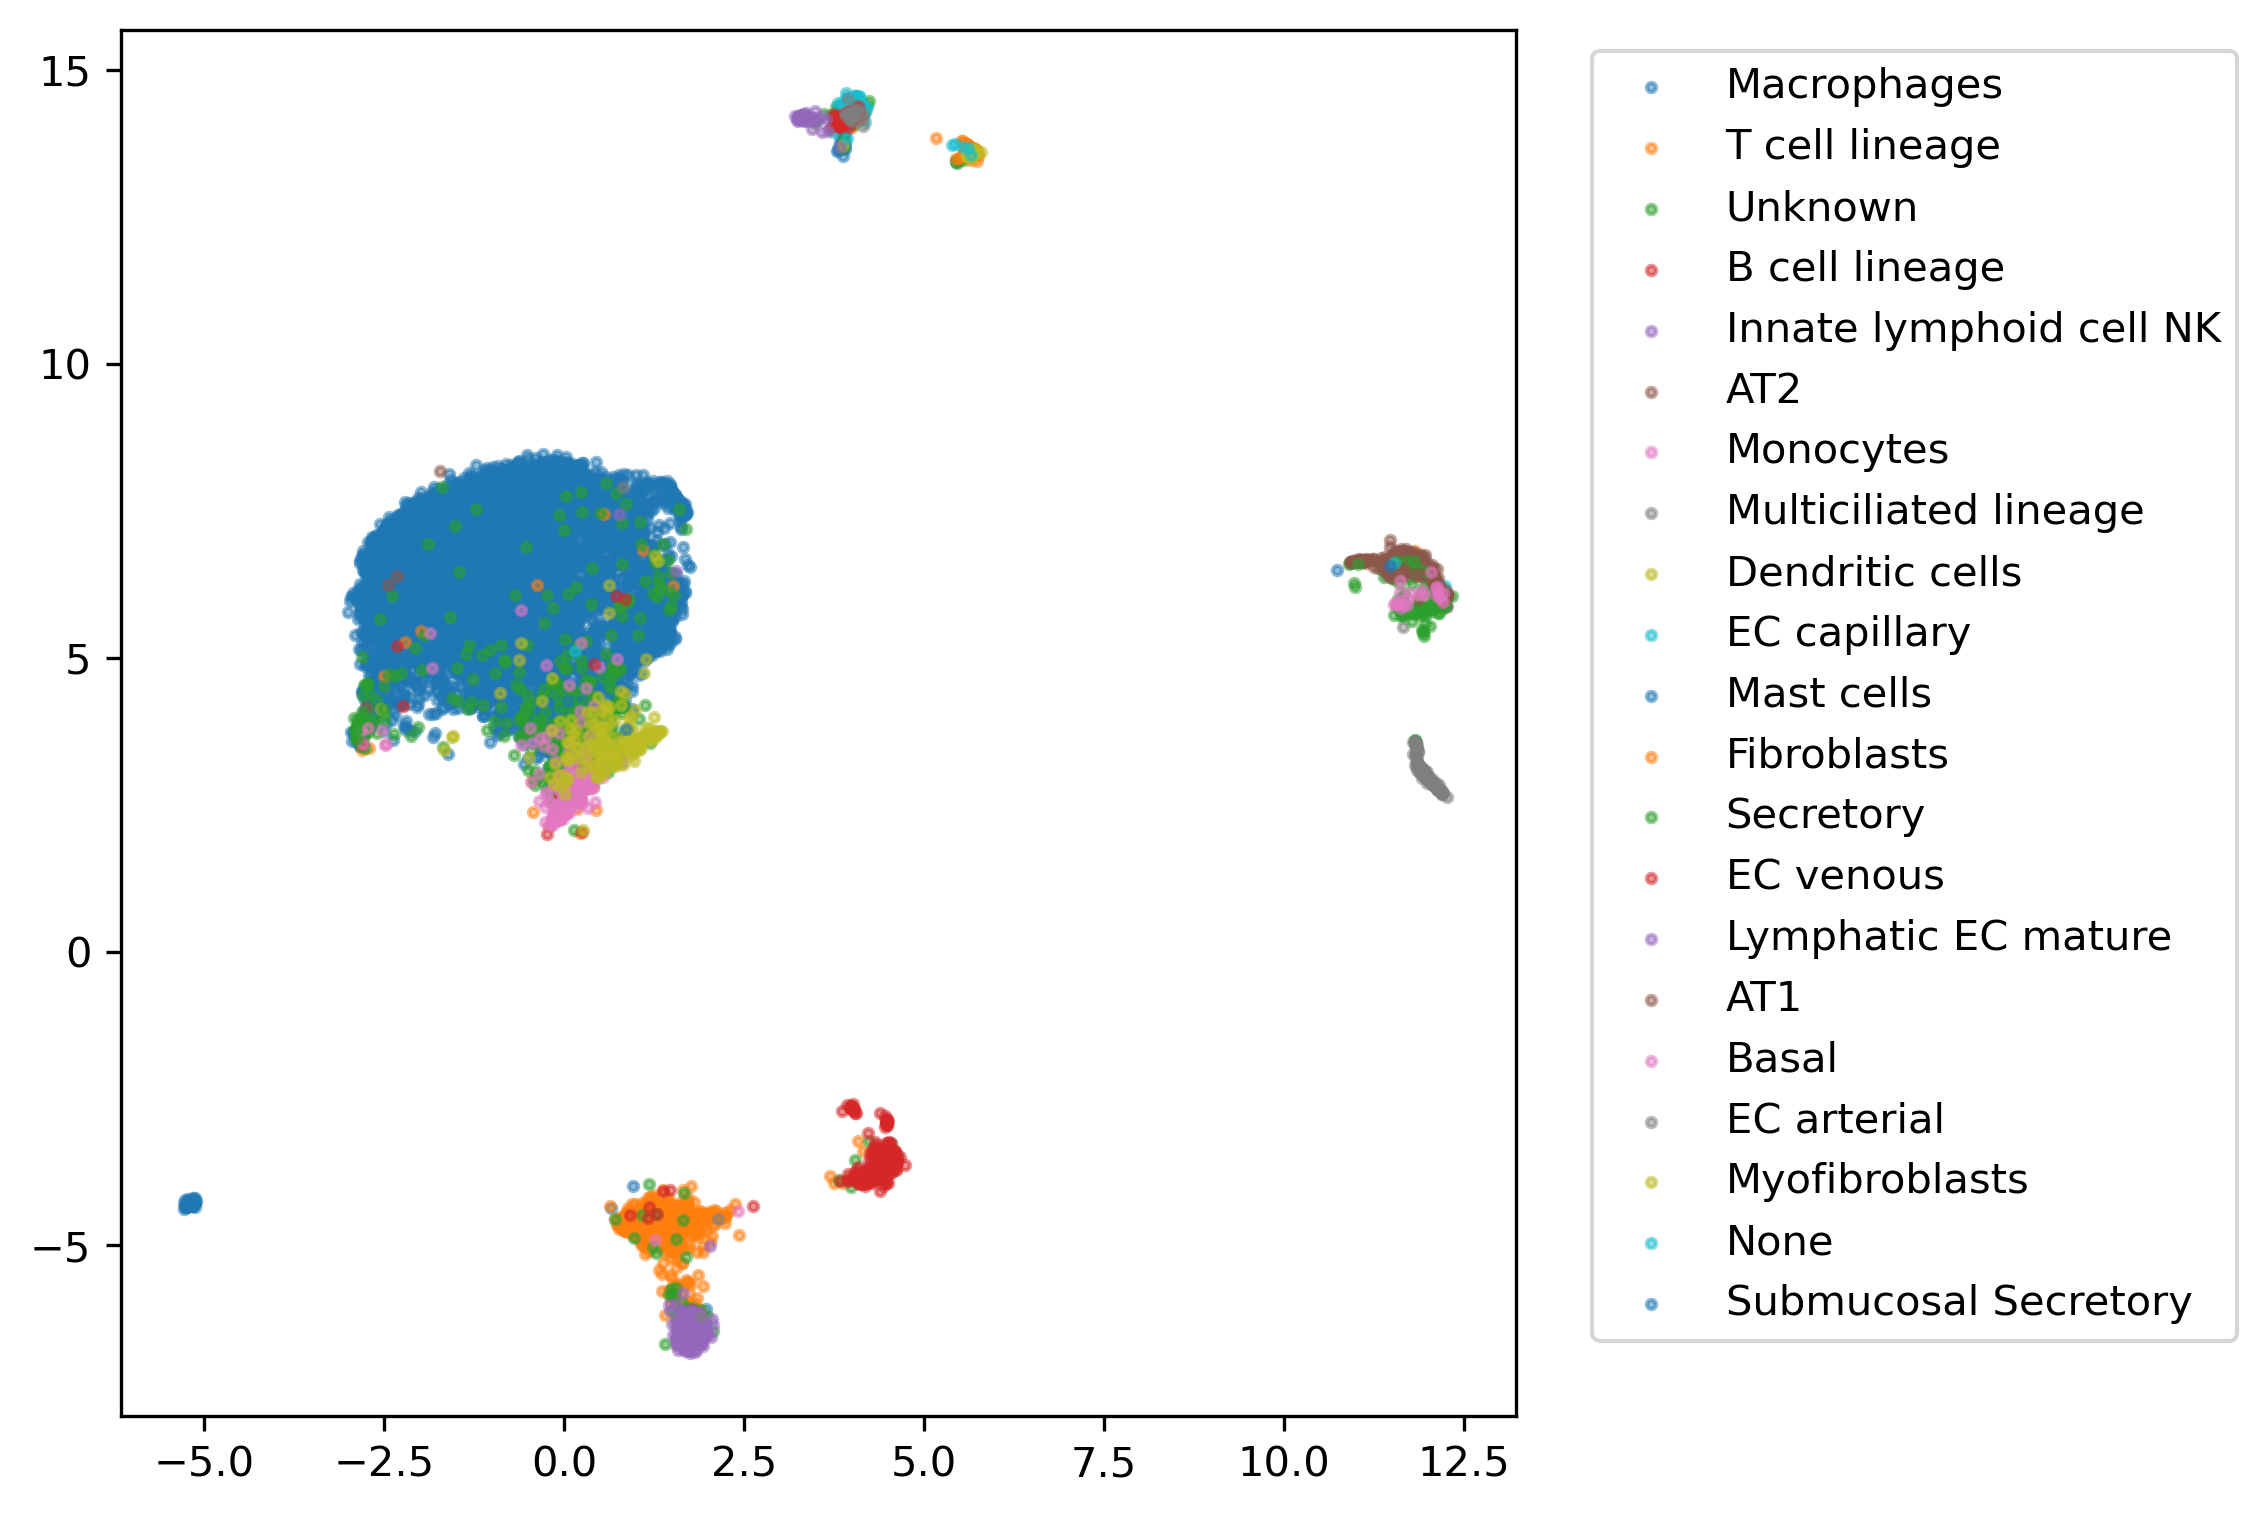

In [70]:
import numpy as np
from sklearn.manifold import TSNE

def umapPlot(embedding,clusters=None,reduce=False,labels=None):
    # if tensor: embedding should be .cpu().detach()
    # clusters: Nxt
    # t里面存的是行的index
    if reduce:
        reducer = umap.UMAP()
#         embedding = TSNE(n_components=2, learning_rate='auto',
#                   init='random', perplexity=3).fit_transform(embedding)
        embedding = reducer.fit_transform(embedding)
    
    plt.figure(figsize=(6,6),dpi=300)
    if clusters is None:
        plt.scatter(embedding[:,0],embedding[:,1],alpha=0.5,s=5)
    else:
        for cluster,label in zip(clusters,labels):
            plt.scatter(embedding[cluster,0],embedding[cluster,1],alpha=0.5,s=5,label=label)
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
         
            
            
umapPlot(cell_embed.cpu().detach().numpy(),reduce=True,
         clusters=cluster_cell_ls,labels=celltype_names)

In [62]:
a=cell_embed.cpu().detach().numpy()

In [66]:
a

array([[0.2833134 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00663263, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.1639814 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.0848366 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [67]:
embedding = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(torch.tensor(a))

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U4'), dtype('float32')) -> None

In [17]:
torch.tensor([[1,2],[3,4]])*torch.tensor([[1,2],[3,4]])

tensor([[ 1,  4],
        [ 9, 16]])

In [3]:
%%time
import torch
from torch import nn, optim
from torch.nn import functional as F
import torch.utils.data as Data
import numpy as np


class AE(nn.Module):
    def __init__(self, dim, emb_dim=128):
        super(AE, self).__init__()
        self.dim = dim
        self.fc1 = nn.Linear(dim, 512)
        self.fc2 = nn.Linear(512, emb_dim)
        self.fc3 = nn.Linear(emb_dim, 512)
        self.fc4 = nn.Linear(512, dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return F.relu(self.fc2(h1))

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.relu(self.fc4(h3))

    def forward(self, x):
        z = self.encode(x.view(-1, self.dim))
        return self.decode(z), z
    
    
feature=torch.tensor(gene_cell.T)
feature=feature.to(device)
model = AE(dim=feature.shape[1]).to(device)
ba=5000
loader = Data.DataLoader(feature, ba)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

loss_func = nn.MSELoss()
EPOCH_AE = 2000
for epoch in range(EPOCH_AE):
    embeddings = []
    # loss_ls=[]
    for _, batch_x in enumerate(loader)	:
        decoded, encoded = model(batch_x)
        loss1 = loss_func(batch_x, decoded)
        loss2 = 0
        for i in range(batch_x.shape[0]):
            for j in range(i+1,batch_x.shape[0]):
                v1=batch_x[i]
                v2=batch_x[j]
                h1=encoded[i]
                h2=encoded[j]
                sim1=get_simi(np.array(v1.cpu()),np.array(v2.cpu()))
                sim2=loss_exp(h1,h2)
                loss2+=sim1*(sim2-sim1).abs()
        print(loss1,loss2)
        loss=loss1+loss2
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        embeddings.append(encoded)
    #     loss_ls.append(loss.item())
    # scheduler.step(np.mean(loss_ls))
    print('Epoch :', epoch, '|', 'train_loss:%.12f' % loss.data)
    break

KeyboardInterrupt: 

25000000